In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
import matplotlib
import utils
import train_bitmap
import train_arithmetic

from importlib import reload

In [67]:
config = utils.DotDict(yaml.safe_load(open('experiments/copy/ntm/config.yaml')))

# customize config
config.load = 'experiments/copy/ntm/checkpoints/NTM-1600.pth'

In [68]:
model, optimizer, loss, train_data, validation_data, step = train_bitmap.setup_model(config)

In [69]:
x, y, m = train_data.gen_batch(1, 30, 30)

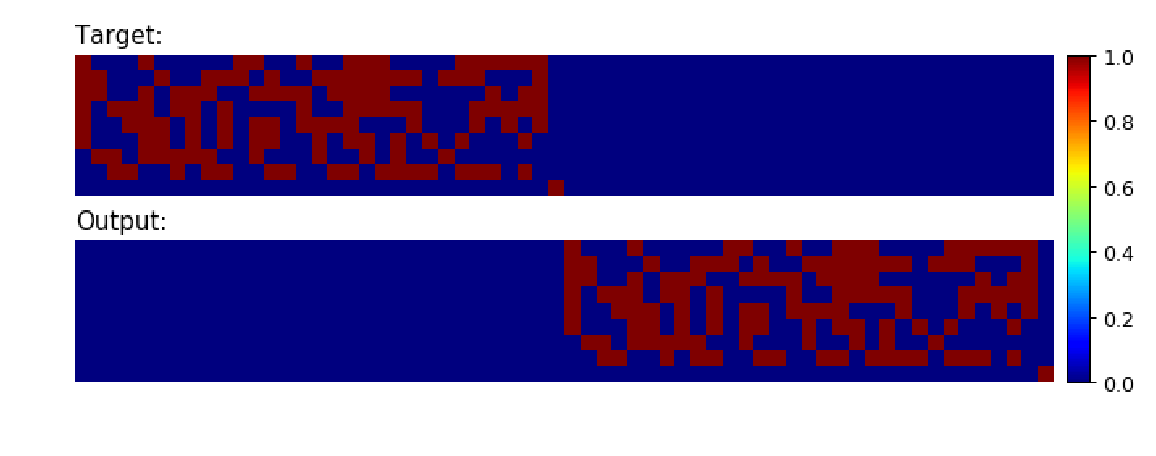

In [70]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(np.rollaxis(utils.input_output_img(x[0].numpy().T, y[0].numpy().T).T, 1, 0))
plt.show()

In [88]:
model.read_head.new_sequence()
model.write_head.new_sequence()
model.controller.new_sequence()
model.mem_init(x.size(0), x.device)

out = []
mem = []
read = []
write = []

for t in range(x.size(1)):
    out.append(model.step(x[:, t], debug=False))
    mem.append(model.memory)
    read.append(model.read_head.get_prev_dist(model.memory))
    write.append(model.write_head.get_prev_dist(model.memory))

In [89]:
torch.sigmoid(torch.stack(out, dim=1)).detach().numpy().shape

(1, 62, 9)

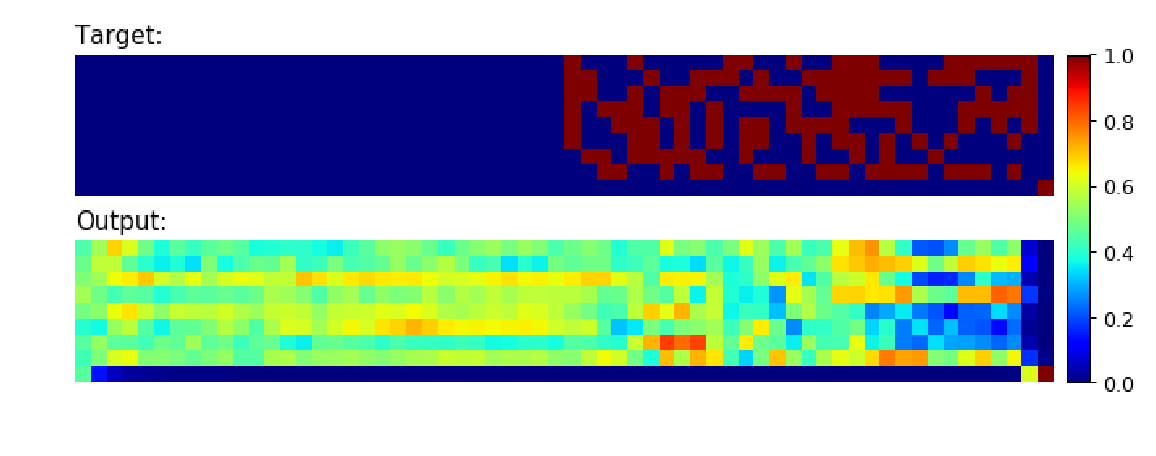

In [90]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(np.rollaxis(utils.input_output_img(y[0].numpy().T, torch.sigmoid(torch.stack(out, dim=1)).detach().numpy()[0].T).T, 1, 0))
plt.show()



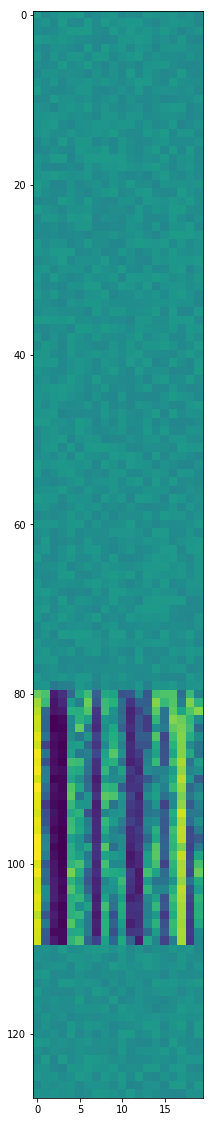

In [91]:
plt.figure(figsize=(20, 20))
plt.imshow(mem[30][0].detach().numpy())
plt.show()

In [92]:
mem[-1].shape

torch.Size([1, 128, 20])

In [93]:
write[-1].shape

torch.Size([1, 1, 128])

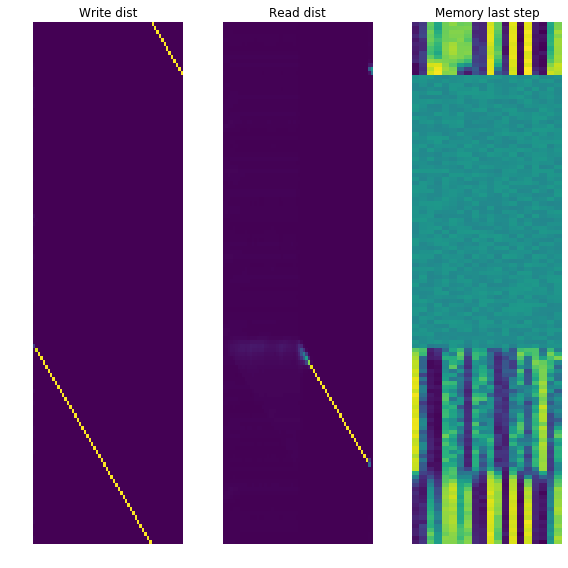

In [94]:
plt.figure(figsize=(8, 8))
for i, (arr, name) in enumerate(zip((write, read), ('Write dist', 'Read dist')), 1):
    plt.subplot(1, 3, i)
    plt.imshow(torch.stack(arr).squeeze().detach().numpy().T, aspect="auto")
    plt.axis('off')
    plt.title(name)

plt.subplot(1, 3, 3)
plt.imshow(mem[-1][0].detach().numpy(), aspect="auto")
plt.axis('off')
plt.title('Memory last step')
    
plt.tight_layout()
plt.show()

# Arithmetic

In [2]:
from tasks.arithmetic import Arithmetic
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
import matplotlib
import utils
import train_bitmap
import train_arithmetic

from importlib import reload

In [6]:
config = utils.DotDict(yaml.safe_load(open('experiments/arithmetic/ntm/config.yaml')))

# customize config
config.load = 'experiments/arithmetic/ntm/checkpoints/NTM-200000.pth'

In [7]:
id_to_char = ['0', '1', '+', '#']

def generate_example(x, example_len):
    s = ''
    _, idx = x[0,:example_len].max(1)
    for elem in idx:
        s += id_to_char[elem.item()]
    return s


def generate_answer(y, example_len):
    s = ''
    _, idx = y[0, example_len+1:].max(1)
    for elem in idx:
        s += id_to_char[elem.item()]
        if elem.item() == 3:
            return s
    return s


def to_dec(s):
    if s.find('+') == -1:
        return str(int(s, 2))
    s1, s2 = s.split('+')
    return to_dec(s1) + '+' + to_dec(s2)


def evaluate(x, y, model, example_len, debug=None):
    ex = generate_example(x, example_len)
    answ = generate_answer(y, example_len)
    print(ex + '=' + answ)
    print(to_dec(ex) + '=' + to_dec(answ[:-1]))
    pred = model(x.cuda())    
    str_pred = generate_answer(pred, example_len)
    print('binary pred:', str_pred)
    #print('decimal pred:', to_dec(str_pred[:-1]))
    return pred
    
def random_example(ex_len):
    x, y, m = train_data.gen_batch(batch_size=1,
                min_len=ex_len, max_len=ex_len,
                distribution=np.array([1,]))
    return evaluate(x, y, model, ex_len)

In [8]:
model, optimizer, loss, train_data, validation_data = train_arithmetic.setup_model(config)

In [14]:
ex_len = 7
x, y, m = train_data.gen_batch(batch_size=1,
                min_len=ex_len, max_len=ex_len,
                distribution=np.array([1,]))
evaluate(x, y, model, ex_len)
info = {}
pred = model(x.cuda(), info)

0+10010=10010#
0+18=18
binary pred: 10010#


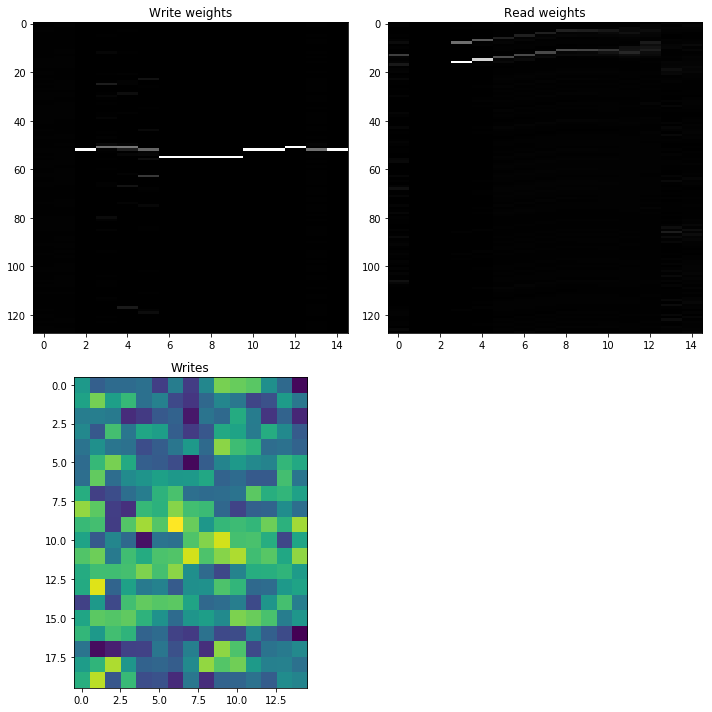

In [15]:
write_weights = np.array([w.squeeze().detach().cpu().numpy() for w in info['write_head']['write_weights']])
read_weights = np.array([w.squeeze().detach().cpu().numpy() for w in info['read_head']['read_weights']])
writes = np.array([w.squeeze().detach().cpu().numpy() for w in info['write_head']['write_vectors']])
                                                                                  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.title('Write weights')
plt.imshow(write_weights.T, cmap='gray', aspect='auto')

plt.subplot(222)
plt.title('Read weights')
plt.imshow(read_weights.T, cmap='gray', aspect='auto')

plt.subplot(223)
plt.title('Writes')
plt.imshow(writes.T, aspect='equal')

plt.tight_layout()
plt.show()

# DNC vizualizations

In [293]:
from importlib import reload

import torch
import yaml
import matplotlib.pyplot as plt
import numpy as np

import train_bitmap
import utils
import tasks.bitmap as bitmap
import models.dnc as dnc

reload(train_bitmap)
reload(utils)
reload(dnc)
reload(bitmap)


<module 'tasks.bitmap' from '/Users/irubachev/ksenia/tasks/bitmap.py'>

In [294]:
with open('/Users/irubachev/ksenia/experiments/copy/dnc/config.yaml') as f:
    config = utils.DotDict(yaml.safe_load(f))
    config.load = '/Users/irubachev/ksenia/experiments/copy/dnc/checkpoints/DNC-9600.pth'
model, optimizer, task, step = train_bitmap.setup(config)

In [295]:
device = 'cuda' if config.gpu and torch.cuda.is_available() else 'cpu'

length = 40
inp, tar, mask = task.gen_batch(1, length, length)
info = {}


n_cells = model.n_cells
model.n_cells = length

out = model(
    inp.to(device),
    debug=info,
)

model.n_cells = n_cells

out = torch.sigmoid(out)
out = out.data.to('cpu').numpy()[0].T
tar = tar.data.numpy()[0].T

io = utils.input_output_img(
    tar,
    out,
)

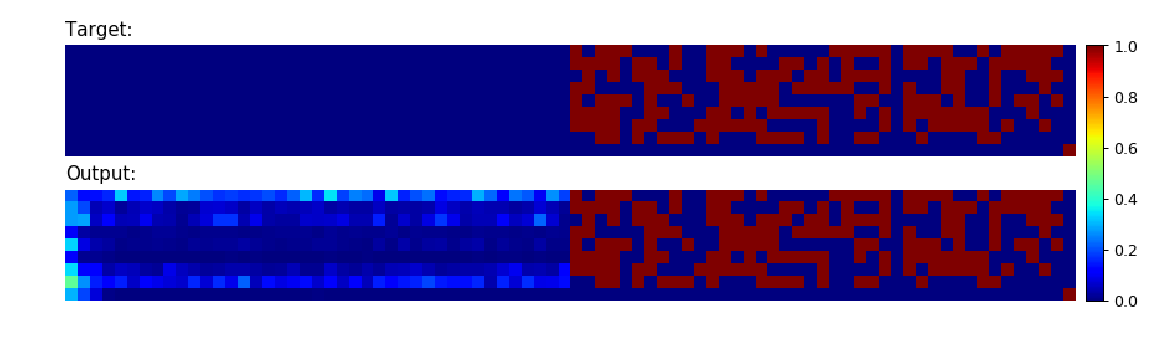

In [296]:
plt.figure(figsize=(20, 10))
plt.imshow(np.moveaxis(io, 0, -1), cmap='gray')
plt.axis('off')
plt.show()

In [302]:
reload(utils)
im = utils.dnc_img(info)

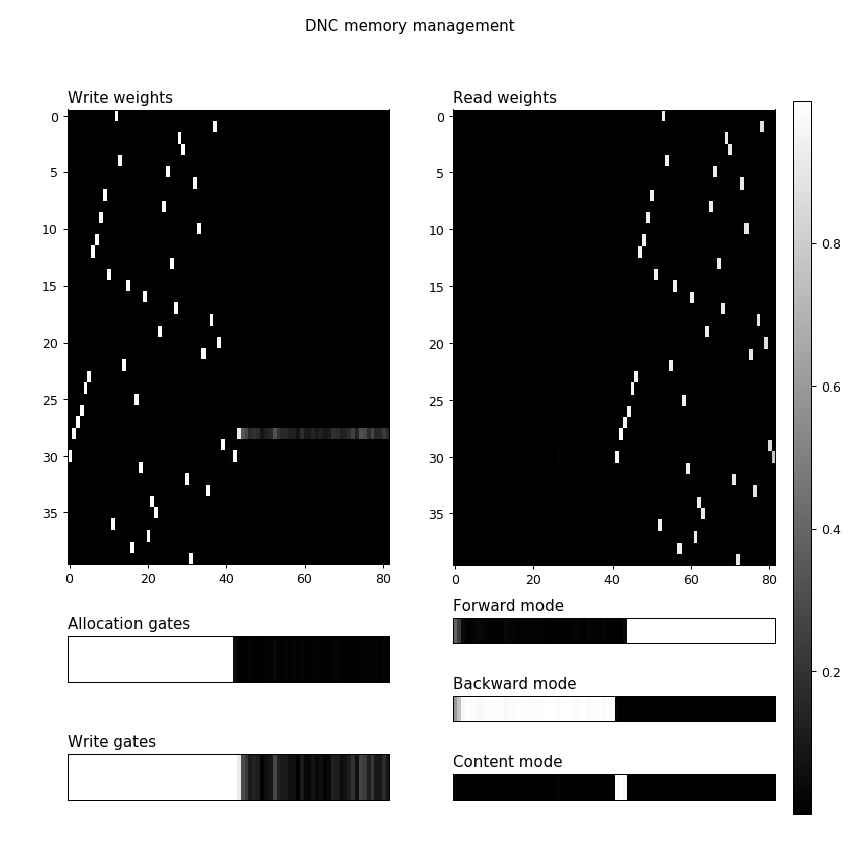

In [303]:
plt.figure(figsize=(15, 15))
plt.imshow(np.moveaxis(im, 0, -1), cmap='gray')
plt.axis('off')
plt.show()